In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import json
import sys
import re
import pickle as pkl
from pathlib import Path
sys.path.append("../src")
from pprint import pprint

import pandas as pd
from matplotlib import pyplot as plt
from joblib import Parallel, delayed
from sklearn.metrics import classification_report

import constants
from evaluate import score, chart
from gen.util import read_data, write_jsonl

# README

`cd /users/k21190024/study/fact-checking-repos/fever/baseline`

Build TF-IDF: `PYTHONPATH=$PYTHONPATH:src /users/k21190024/study/fact-checking-repos/fever/baseline/src/scripts/build_tfidf.py /users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/feverised-climatefever-titleid.db /users/k21190024/study/fact-checking-repos/fever/baseline/fever2-sample/data/index --num-workers 10`

__No need to sample NEI class as Climate-FEVER has evidences for every NEI claim__

IR Tuning: Tune for _k_ nearest pages and _l_ nearest sentences where 1 <= k <= 10 and 1 <= l <= 10 using grid search

RTE Fine Tune: `PYTHONPATH=$PYTHONPATH:src allennlp fine-tune -m /users/k21190024/study/fact-checking-repos/fever/baseline/fever2-sample/data/models/seeded-decomposable_attention.tar.gz -s /users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/rte/[DUMP_PATH] -c /users/k21190024/study/fact-checking-repos/fever/baseline/config/finetune_climatefever_nn_ora_sent.json -o '{"dataset_reader":{"database":"/users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/feverised-climatefever-titleid.db"}}' --include-package rte.parikh.reader`

# IR

In [5]:
ir_p = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/ir")

## Get evaluate results

In [5]:
def multi_ir_evaluate(train_p, dev_p, max_evidence=None):
    train, dev = read_data(train_p), read_data(dev_p)
    train_keys = re.findall(r".*(p\d{1,2})\.(s\d{1,2})", train_p.stem)[0]
    dev_keys = re.findall(r".*(p\d{1,2})\.(s\d{1,2})", dev_p.stem)[0]
    
    key = "".join(train_keys)
    if key != "".join(dev_keys):
        raise Exception("Train and dev files are different! ({0} != {1})".format(train_p.stem, dev_p.stem))
    
    try:
        res = {
            key: {
                "train": score.ClimateFEVERScorer(train, train, oracle_rte=True, oracle_ir=False, max_evidence=max_evidence, score_name="train"),
                "dev": score.ClimateFEVERScorer(dev, dev, oracle_rte=True, oracle_ir=False, max_evidence=max_evidence, score_name="dev")
            }
        }
    except:
        raise Exception(train_p.stem, dev_p.stem)
    else:
        return res

In [72]:
train_pls = sorted(list(ir_p.joinpath("train").iterdir()))
dev_pls = sorted(list(ir_p.joinpath("dev").iterdir()))

eval_nomaxev = Parallel(n_jobs=20)(delayed(multi_ir_evaluate)(tp, dp, None) for tp, dp in zip(train_pls, dev_pls))
with ir_p.joinpath("eval_nomaxevidence.pkl").open("wb") as fn:
    pkl.dump(eval_nomaxev, fn)
    
eval_max5ev = Parallel(n_jobs=20)(delayed(multi_ir_evaluate)(tp, dp, 5) for tp, dp in zip(train_pls, dev_pls))
with ir_p.joinpath("eval_max5evidences.pkl").open("wb") as fn:
    pkl.dump(eval_max5ev, fn)

## Analyse results

In [75]:
with ir_p.joinpath("eval_nomaxevidence.pkl").open("rb") as f1, ir_p.joinpath("eval_max5evidences.pkl").open("rb") as f2:
    eval_nomaxevidence = pkl.load(f1)
    eval_max5evidences = pkl.load(f2)

In [76]:
def to_df(ev_res):
    key = list(ev_res.keys())[0]
    p, s = re.findall(r".*p(\d{1,2})s(\d{1,2})", key)[0]
    
    res = {"n_pages": int(p), "n_sents": int(s)}
    res.update(ev_res[key]["train"].score_to_dict())
    res.update(ev_res[key]["dev"].score_to_dict())
    
    return res

In [77]:
df_evnomax = Parallel(n_jobs=10)(delayed(to_df)(ev) for ev in eval_nomaxevidence)
df_ev5max = Parallel(n_jobs=10)(delayed(to_df)(ev) for ev in eval_max5evidences)

df_evnomax = pd.DataFrame(df_evnomax).sort_values(["n_pages", "n_sents"])
df_ev5max = pd.DataFrame(df_ev5max).sort_values(["n_pages", "n_sents"])

### No max evidence

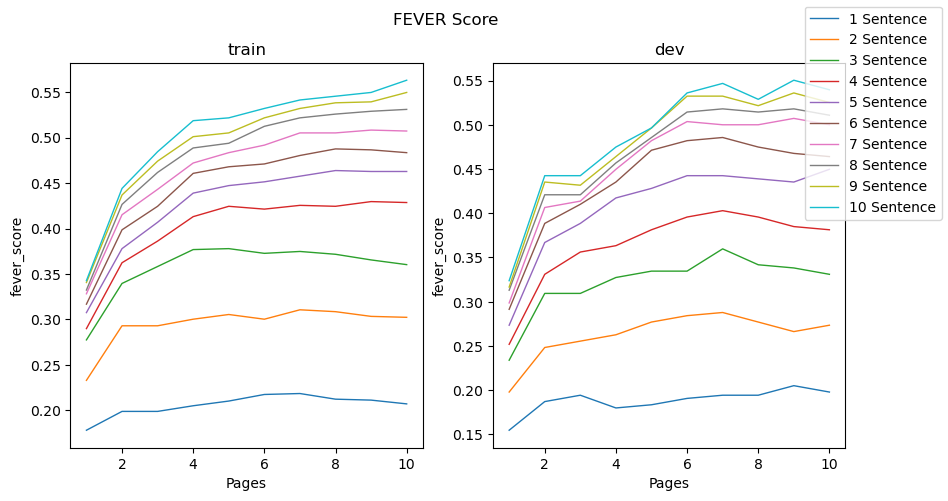

In [172]:
fig_fs, ax_fs = chart.plot_evidence_curves(df_evnomax, x_is_page=True, metric="fever_score", suptitle="FEVER Score")

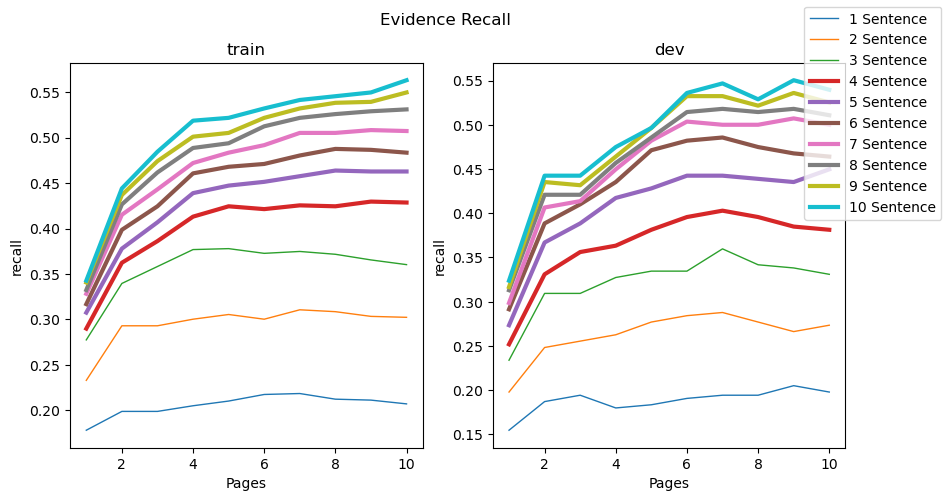

In [177]:
fig_r, ax_r = chart.plot_evidence_curves(df_evnomax, x_is_page=True, metric="recall", suptitle="Evidence Recall", bold_line_index=[4, 5, 6, 7, 8, 9, 10])

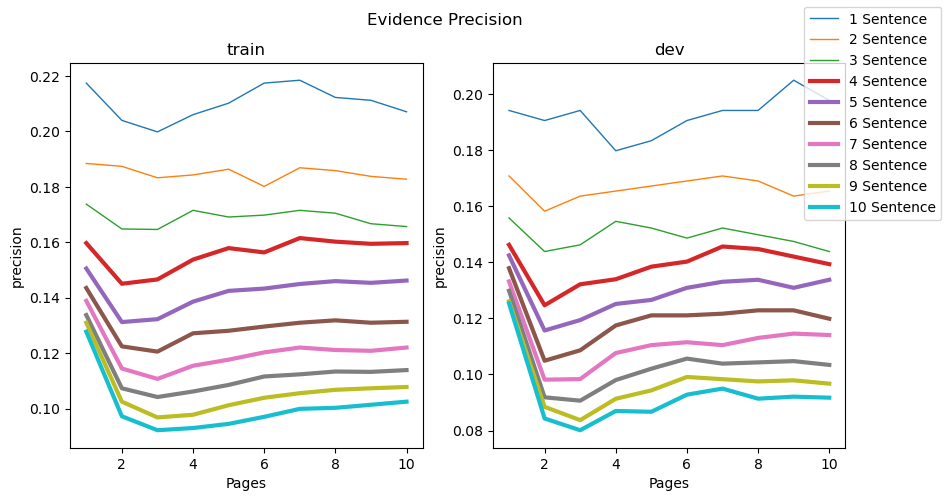

In [181]:
fig_p, ax_p = chart.plot_evidence_curves(df_evnomax, x_is_page=True, metric="precision", suptitle="Evidence Precision", bold_line_index=list(range(4, 11)))

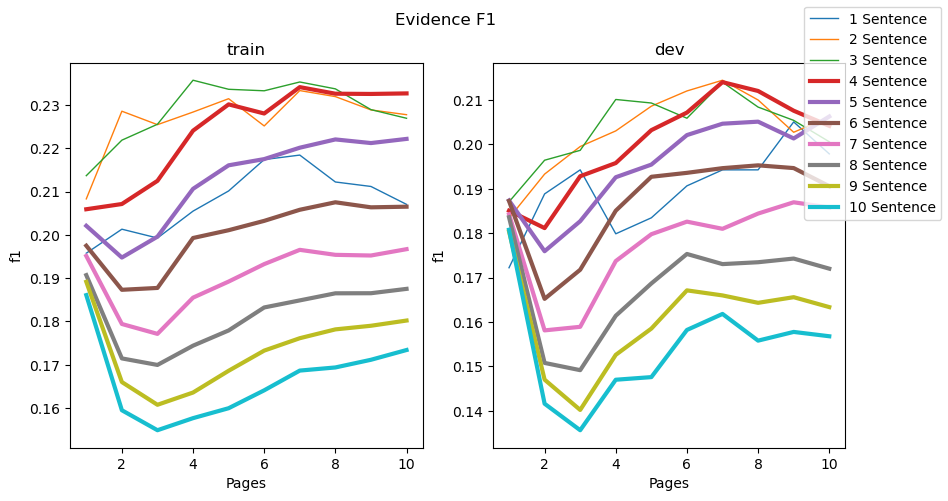

In [180]:
fig_f1, ax_f1 = chart.plot_evidence_curves(df_evnomax, x_is_page=True, metric="f1", suptitle="Evidence F1", bold_line_index=[4, 5, 6, 7, 8, 9, 10])

# RTE

## Analyse loss curve

In [6]:
model_p = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/rte")

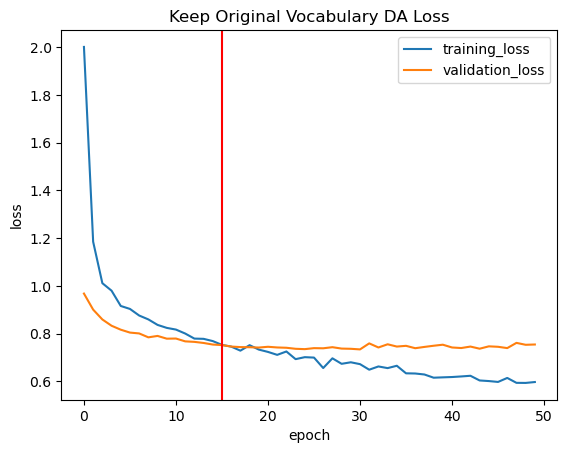

In [52]:
ax, keep_met = chart.plot_finetune(model_p / "keep-vocab_model-50epoch_sgd-lr-0.001", metric="loss", return_metric=True)
ax.set_title("Keep Original Vocabulary DA Loss")
ax.axvline(x=15, color="r")

In [53]:
keep_met["bias_variance"] = keep_met["training_loss"] - keep_met["validation_loss"]
keep_met[keep_met["bias_variance"] == keep_met.loc[keep_met["bias_variance"] >= 0, "bias_variance"].min()]

,best_epoch,peak_cpu_memory_MB,peak_gpu_0_memory_MB,training_duration,training_start_epoch,training_epochs,epoch,training_accuracy,training_macro_precision,training_macro_recall,...,validation_loss,best_validation_accuracy,best_validation_macro_precision,best_validation_macro_recall,best_validation_macro_fscore,best_validation_micro_precision,best_validation_micro_recall,best_validation_micro_fscore,best_validation_loss,bias_variance
19,15,4682.168,6548,0:00:14.897444,0,15,15,0.651139,0.614022,0.564365,...,0.752446,0.676259,0.611512,0.573559,0.555541,0.676259,0.676259,0.676259,0.752446,0.000853


In [114]:
keep_met["validation_loss_lag1"] = keep_met["validation_loss"].diff(periods=1)
keep_met[["validation_loss", "validation_loss_lag1"]]

,validation_loss,validation_loss_lag1
41,0.968081,NaN
18,0.900872,-0.067209
27,0.859677,-0.041196
6,0.833412,-0.026265
46,0.816849,-0.016563
8,0.804746,-0.012103
49,0.801194,-0.003552
13,0.784854,-0.016340
35,0.790767,0.005913
5,0.779265,-0.011502


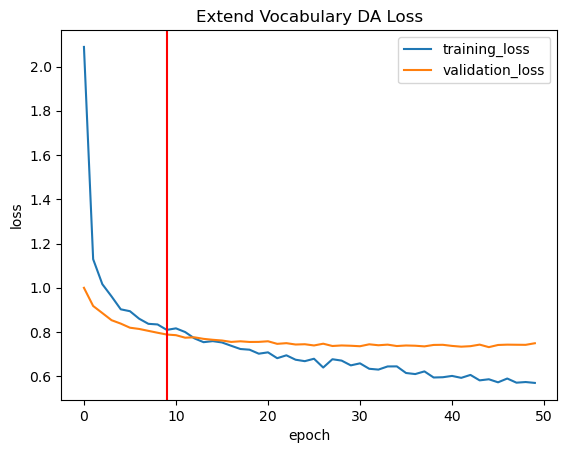

In [65]:
ax, expand_met = chart.plot_finetune(model_p / "extend-vocab_model-50epoch_sgd-lr-0.001", metric="loss", return_metric=True)
ax.set_title("Extend Vocabulary DA Loss")
ax.axvline(x=9, color="r")

In [58]:
expand_met["bias_variance"] = expand_met["training_loss"] - expand_met["validation_loss"]
expand_met[expand_met["bias_variance"] == expand_met.loc[expand_met["bias_variance"] >= 0, "bias_variance"].min()]

,best_epoch,peak_cpu_memory_MB,peak_gpu_0_memory_MB,training_duration,training_start_epoch,training_epochs,epoch,training_accuracy,training_macro_precision,training_macro_recall,...,validation_loss,best_validation_accuracy,best_validation_macro_precision,best_validation_macro_recall,best_validation_macro_fscore,best_validation_micro_precision,best_validation_micro_recall,best_validation_micro_fscore,best_validation_loss,bias_variance
5,9,4700.924,13105,0:00:15.205098,0,9,9,0.658385,0.62861,0.57002,...,0.788482,0.672662,0.601322,0.570881,0.536327,0.672662,0.672662,0.672662,0.788482,0.021012


In [64]:
expand_met["validation_loss_lag1"] = expand_met["validation_loss"].diff(periods=1)
expand_met[["epoch", "validation_loss", "validation_loss_lag1"]]

,epoch,validation_loss,validation_loss_lag1
41,0,0.999722,NaN
18,1,0.917575,-0.082147
27,2,0.885526,-0.032049
6,3,0.853309,-0.032217
46,4,0.837880,-0.015429
8,5,0.819332,-0.018548
49,6,0.813775,-0.005557
13,7,0.805126,-0.008650
35,8,0.796556,-0.008570
5,9,0.788482,-0.008074


### Extended Vocabulary

In [66]:
with open("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/rte/extend-vocab_model-50epoch_sgd-lr-0.001/vocabulary/tokens.txt", "r") as fn:
    extended_vocab_ls = fn.readlines()
with open("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/rte/keep-vocab_model-50epoch_sgd-lr-0.001/vocabulary/tokens.txt", "r") as fn:
    keep_vocab_ls = fn.readlines()

In [68]:
len(extended_vocab_ls), len(keep_vocab_ls)

(76271, 67865)

In [70]:
diff_vocab = set(extended_vocab_ls) - set(keep_vocab_ls)
len(diff_vocab)

8406

In [71]:
diff_vocab

{'(ipcc,\n',
 'fingerprinting\n',
 'record-low\n',
 'lag,\n',
 'perturbation.\n',
 'e-class\n',
 'eu-15\n',
 'indonesia,\n',
 'false…although\n',
 '(2000,\n',
 'unep\n',
 'tlt\n',
 '(apg)\n',
 'self-reinforcing\n',
 '"resource\n',
 'standards,\n',
 'bromofluorocarbons,\n',
 'intense,\n',
 'enzymatic\n',
 '°c)+\n',
 'chamber,\n',
 'stronger,\n',
 'case,\n',
 'understanding,\n',
 'crucially,\n',
 '(ppm)\n',
 'summary,\n',
 'transitions\n',
 'overlie\n',
 '1934.\n',
 'previously,\n',
 '(uncontrolled\n',
 'widespread.\n',
 'diffusion.\n',
 'kilowatts\n',
 'efficiency;\n',
 '280%\n',
 'solubility\n',
 '−364\n',
 '2050,\n',
 'time:\n',
 'unavoidable.\n',
 '192-nation\n',
 'days.\n',
 'discredits\n',
 'warms\n',
 'onsite\n',
 'health,\n',
 'zika\n',
 'decades.\n',
 'machine,\n',
 'clouds,\n',
 'toronto,\n',
 'law"\n',
 'process,\n',
 'world.\n',
 'photosynthesis,\n',
 '(124\n',
 '(far)\n',
 'polarity\n',
 'theory.\n',
 'variations,\n',
 '(2005),\n',
 'portugal,\n',
 '14,\n',
 'endeavor.\n',
 

## Evaluate Pipeline

Oracle IR is the absolute best the model can achieve assuming IR is perfect

In [91]:
def multi_rte_score(actual_train, actual_dev, predicted_p):
    predicted_train = read_data(predicted_p / "pred.train.jsonl")
    predicted_dev = read_data(predicted_p / "pred.dev.jsonl")
    
    key = predicted_p.stem
    return {
        key: {
            "train": score.ClimateFEVERScorer(actual_train, [{"predicted": pred["predicted_label"]} for pred in predicted_train], oracle_ir=True, oracle_rte=False, max_evidence=None, score_name=f"{key}_train"),
            "dev": score.ClimateFEVERScorer(actual_dev, [{"predicted": pred["predicted_label"]} for pred in predicted_dev], oracle_ir=True, oracle_rte=False, max_evidence=None, score_name=f"{key}_dev")
        }
    }

def rte_eval_to_df(eval_ls):
    df = []
    for i in eval_ls:
        k = list(i.keys())[0]
        v = i[k]

        eval_d = {}
        p, s = re.findall(r"p(\d{1,2})s(\d{1,2}).*", k)[0]
        p, s = int(p), int(s)
        if p == 0 and s == 0:
            key = "oracle_ir"
        else:
            key = "p" + (f"0{p}" if p <= 9 else "10") + "s" + (f"0{s}" if s <= 9 else "10")

        eval_d["n_pages"] = p
        eval_d["n_sents"] = s
        eval_d["ir_type"] = key

        for split, res in v.items():
            for name, met in res.rte_metrics.items():
                eval_d[f"{split}_{name}"] = met
        df.append(eval_d)

    df = pd.DataFrame(df).sort_values(["n_pages", "n_sents"])
    
    return df

In [92]:
pipeline_p = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/pipeline")

cf_train = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/finetune/baseline/climatefever_train.jsonl"))
cf_dev = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/finetune/baseline/climatefever_dev.jsonl"))
cf_test = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/dumps/feverised-climatefever/finetune/baseline/climatefever_test.jsonl"))

### Decomposition Attention Model

Keep-vocab trained for 15 epoch

Extend-vocab trained for 9 epoch

In [128]:
pipeline_keep = pipeline_p / "keep-vocab_model-15epoch_sgd-lr-0.001"
pipeline_extend = pipeline_p / "extend-vocab_model-9epoch_sgd-lr-0.001"

keep_rte_eval = Parallel(n_jobs=20)(delayed(multi_rte_score)(cf_train, cf_dev, p) for p in pipeline_keep.iterdir())
with pipeline_p.joinpath("eval_keep-vocab.pkl").open("wb") as fn:
    pkl.dump(keep_rte_eval, fn)
    
extend_rte_eval = Parallel(n_jobs=20)(delayed(multi_rte_score)(cf_train, cf_dev, p) for p in pipeline_extend.iterdir())
with pipeline_p.joinpath("eval_extend-vocab.pkl").open("wb") as fn:
    pkl.dump(extend_rte_eval, fn)

In [129]:
with pipeline_p.joinpath("eval_keep-vocab.pkl").open("rb") as fn:
    keep_rte_eval = pkl.load(fn)
    
with pipeline_p.joinpath("eval_extend-vocab.pkl").open("rb") as fn:
    extend_rte_eval = pkl.load(fn)

In [130]:
df_keep = rte_eval_to_df(keep_rte_eval)
df_extend = rte_eval_to_df(extend_rte_eval)

In [131]:
df_keep.nlargest(2, "dev_macro_f1")

,n_pages,n_sents,ir_type,train_fever_score,train_accuracy,train_micro_precision,train_micro_recall,train_micro_f1,train_macro_precision,train_macro_recall,train_macro_f1,dev_fever_score,dev_accuracy,dev_micro_precision,dev_micro_recall,dev_micro_f1,dev_macro_precision,dev_macro_recall,dev_macro_f1
33,0,0,oracle_ir,0.654244,0.654244,0.654244,0.654244,0.654244,0.621763,0.551558,0.542165,0.636691,0.636691,0.636691,0.636691,0.636691,0.477751,0.514909,0.481011
12,5,4,p05s04,0.451346,0.451346,0.451346,0.451346,0.451346,0.448769,0.389805,0.353835,0.478417,0.478417,0.478417,0.478417,0.478417,0.478639,0.409776,0.374749


In [132]:
df_keep.nlargest(2, "dev_fever_score")

,n_pages,n_sents,ir_type,train_fever_score,train_accuracy,train_micro_precision,train_micro_recall,train_micro_f1,train_macro_precision,train_macro_recall,train_macro_f1,dev_fever_score,dev_accuracy,dev_micro_precision,dev_micro_recall,dev_micro_f1,dev_macro_precision,dev_macro_recall,dev_macro_f1
33,0,0,oracle_ir,0.654244,0.654244,0.654244,0.654244,0.654244,0.621763,0.551558,0.542165,0.636691,0.636691,0.636691,0.636691,0.636691,0.477751,0.514909,0.481011
12,5,4,p05s04,0.451346,0.451346,0.451346,0.451346,0.451346,0.448769,0.389805,0.353835,0.478417,0.478417,0.478417,0.478417,0.478417,0.478639,0.409776,0.374749


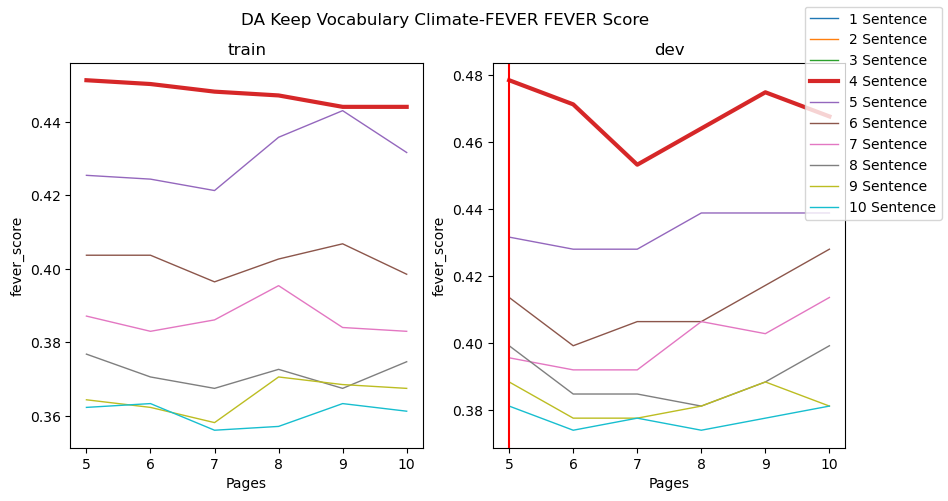

In [133]:
fig_fs, ax_fs = plot_evidence_curves(
    df_keep, 
    x_is_page=True, 
    metric="fever_score", 
    suptitle="DA Keep Vocabulary Climate-FEVER FEVER Score",
    bold_line_index=4
)
ax_fs[1].axvline(x=5, color="r")

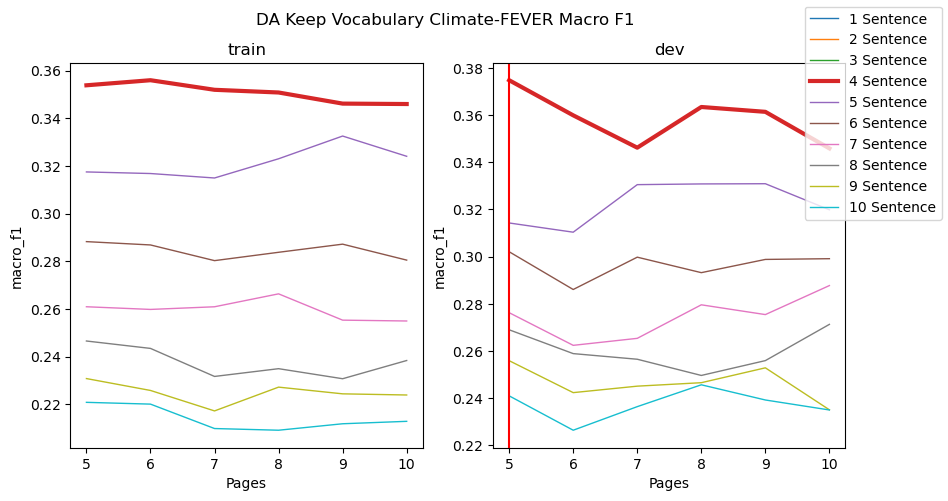

In [134]:
fig_fs, ax_fs = plot_evidence_curves(
    df_keep, 
    x_is_page=True, 
    metric="macro_f1", 
    suptitle="DA Keep Vocabulary Climate-FEVER Macro F1",
    bold_line_index=4
)
ax_fs[1].axvline(x=5, color="r")

In [135]:
df_extend.nlargest(2, "dev_macro_f1")

,n_pages,n_sents,ir_type,train_fever_score,train_accuracy,train_micro_precision,train_micro_recall,train_micro_f1,train_macro_precision,train_macro_recall,train_macro_f1,dev_fever_score,dev_accuracy,dev_micro_precision,dev_micro_recall,dev_micro_f1,dev_macro_precision,dev_macro_recall,dev_macro_f1
33,0,0,oracle_ir,0.581781,0.581781,0.581781,0.581781,0.581781,0.561723,0.498640,0.504402,0.597122,0.597122,0.597122,0.597122,0.597122,0.543538,0.498486,0.498038
20,9,5,p09s05,0.475155,0.475155,0.475155,0.475155,0.475155,0.479513,0.413898,0.420871,0.496403,0.496403,0.496403,0.496403,0.496403,0.473262,0.437921,0.444003


In [136]:
df_extend.nlargest(2, "dev_fever_score")

,n_pages,n_sents,ir_type,train_fever_score,train_accuracy,train_micro_precision,train_micro_recall,train_micro_f1,train_macro_precision,train_macro_recall,train_macro_f1,dev_fever_score,dev_accuracy,dev_micro_precision,dev_micro_recall,dev_micro_f1,dev_macro_precision,dev_macro_recall,dev_macro_f1
33,0,0,oracle_ir,0.581781,0.581781,0.581781,0.581781,0.581781,0.561723,0.498640,0.504402,0.597122,0.597122,0.597122,0.597122,0.597122,0.543538,0.498486,0.498038
11,9,8,p09s08,0.463768,0.463768,0.463768,0.463768,0.463768,0.477001,0.409884,0.414964,0.510791,0.510791,0.510791,0.510791,0.510791,0.491245,0.443781,0.440797


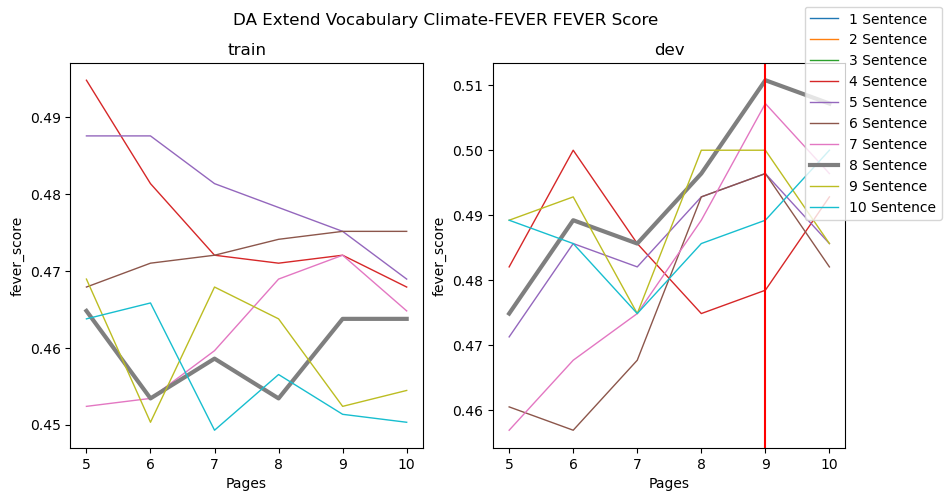

In [137]:
fig_fs, ax_fs = plot_evidence_curves(
    df_extend, 
    x_is_page=True, 
    metric="fever_score", 
    suptitle="DA Extend Vocabulary Climate-FEVER FEVER Score",
    bold_line_index=8
)
ax_fs[1].axvline(x=9, color="r")

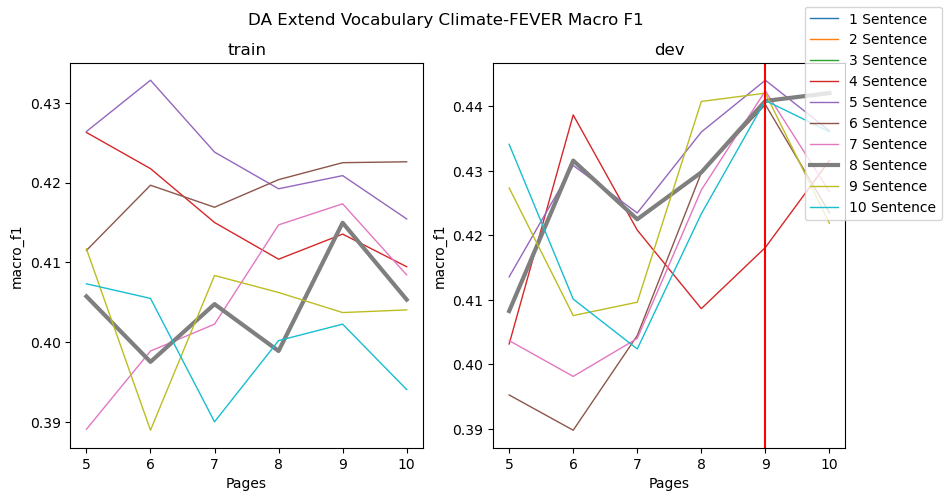

In [138]:
fig_fs, ax_fs = plot_evidence_curves(
    df_extend, 
    x_is_page=True, 
    metric="macro_f1", 
    suptitle="DA Extend Vocabulary Climate-FEVER Macro F1",
    bold_line_index=8
)
ax_fs[1].axvline(x=9, color="r")

#### Compare between best keep/extend vocabulary and zero-shot Climate-FEVER

In [139]:
cfever_zeroshot_p = Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/cfever_zeroshot")

##### Oracle IR

In [140]:
cfever_p0s0_zeroshot = read_data(cfever_zeroshot_p / "p0s0_oracle_ir_dev" / "pred.climatefever_oracle_dev.jsonl")
cfever_p0s0_zeroshot_eval = score.ClimateFEVERScorer(cf_dev, cfever_p0s0_zeroshot, oracle_ir=True, oracle_rte=False, max_evidence=None)
print(cfever_p0s0_zeroshot_eval.classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.13      0.09      0.11        95
        REFUTES       0.22      0.41      0.29        51
       SUPPORTS       0.50      0.44      0.47       132

       accuracy                           0.32       278
      macro avg       0.29      0.32      0.29       278
   weighted avg       0.33      0.32      0.31       278



In [141]:
cfever_p0s0_zeroshot_eval.rte_metrics

{'fever_score': 0.31654676258992803,
 'accuracy': 0.31654676258992803,
 'micro_precision': 0.31654676258992803,
 'micro_recall': 0.31654676258992803,
 'micro_f1': 0.31654676258992803,
 'macro_precision': 0.28606228800493366,
 'macro_recall': 0.31529849579385183,
 'macro_f1': 0.2896822991683777}

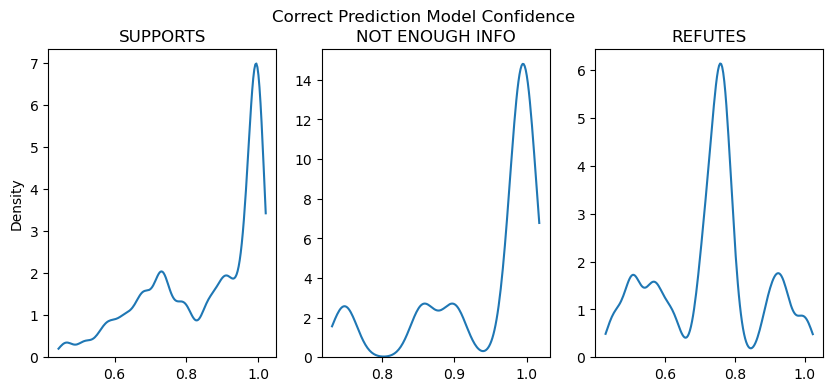

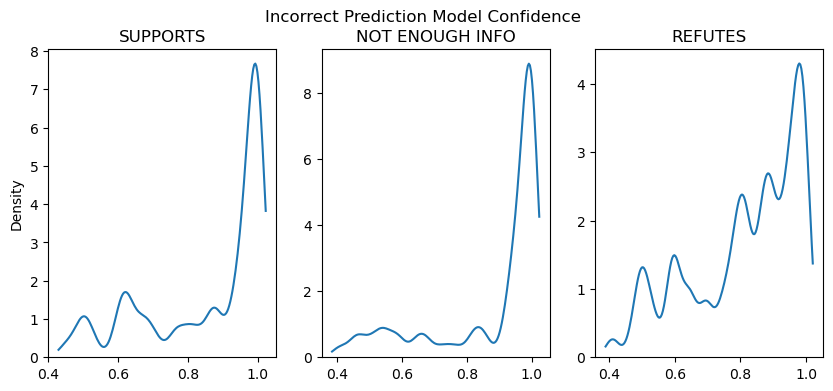

In [171]:
tmp_labels = read_data(cfever_zeroshot_p / "p0s0_oracle_ir_dev" / "predstage" / "labels.climatefever_oracle_dev.jsonl")
_, _ = chart.plot_model_confidence(cf_dev, tmp_labels)

In [142]:
for i in keep_rte_eval:
    if list(i.keys())[0] == "p0s0_oracle_ir":
        best_keep = i["p0s0_oracle_ir"]
        break
print(best_keep["dev"].classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.68      0.68      0.68        95
        REFUTES       0.11      0.02      0.03        51
       SUPPORTS       0.64      0.84      0.73       132

       accuracy                           0.64       278
      macro avg       0.48      0.51      0.48       278
   weighted avg       0.56      0.64      0.58       278



In [143]:
pprint(best_keep["dev"].rte_metrics)

{'accuracy': 0.6366906474820144,
 'fever_score': 0.6366906474820144,
 'macro_f1': 0.4810113519091847,
 'macro_precision': 0.47775089063655307,
 'macro_recall': 0.5149091534540452,
 'micro_f1': 0.6366906474820144,
 'micro_precision': 0.6366906474820144,
 'micro_recall': 0.6366906474820144}


/users/k21190024/study/fact-check-transfer-learning/nb/03_CFEVER_Zero_Shot/../src/evaluate/chart.py:41: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  _ = sns.kdeplot(x=correct_preds[label], bw_adjust=.3, cut=1, ax=ax[i])


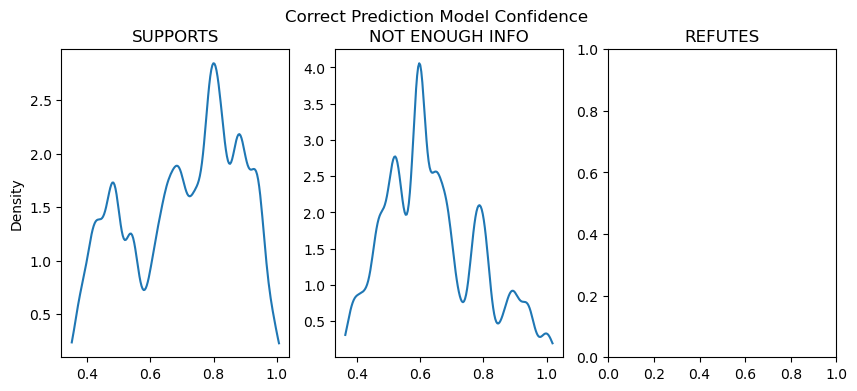

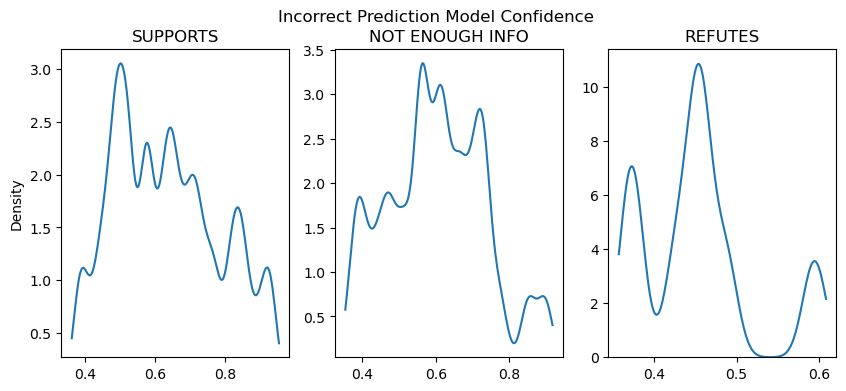

In [168]:
tmp_labels = read_data(pipeline_keep / "p0s0_oracle_ir" / "labels.dev.jsonl")
_, _ = chart.plot_model_confidence(cf_dev, tmp_labels)

In [144]:
for i in extend_rte_eval:
    if list(i.keys())[0] == "p0s0_oracle_ir":
        best_extend = i["p0s0_oracle_ir"]
        break
print(best_extend["dev"].classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.71      0.51      0.59        95
        REFUTES       0.33      0.16      0.21        51
       SUPPORTS       0.59      0.83      0.69       132

       accuracy                           0.60       278
      macro avg       0.54      0.50      0.50       278
   weighted avg       0.58      0.60      0.57       278



In [145]:
pprint(best_extend["dev"].rte_metrics)

{'accuracy': 0.5971223021582733,
 'fever_score': 0.5971223021582733,
 'macro_f1': 0.49803809597304216,
 'macro_precision': 0.5435378452456252,
 'macro_recall': 0.49848641210870315,
 'micro_f1': 0.5971223021582733,
 'micro_precision': 0.5971223021582733,
 'micro_recall': 0.5971223021582733}


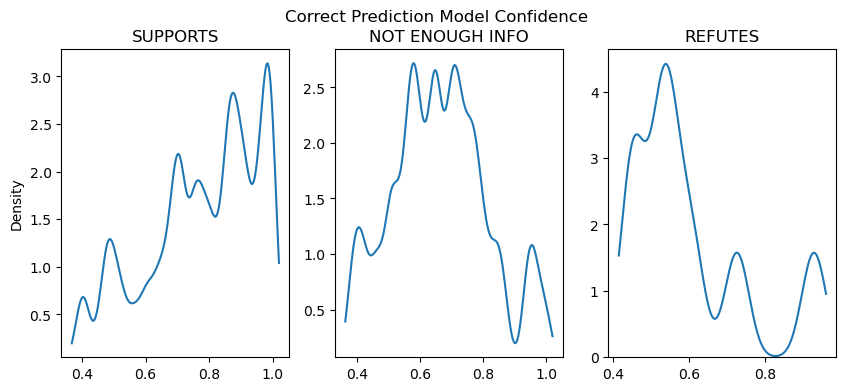

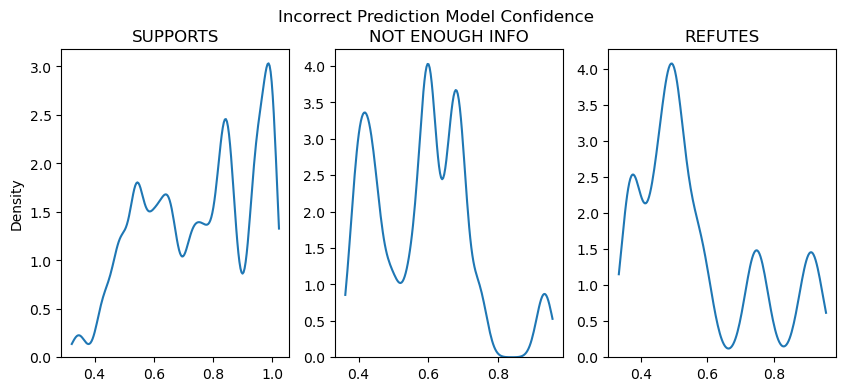

In [167]:
tmp_labels = read_data(pipeline_extend / "p0s0_oracle_ir" / "labels.dev.jsonl")
_, _ = chart.plot_model_confidence(cf_dev, tmp_labels)

##### DEV Pipeline

In [156]:
cfever_p5s5_zeroshot = read_data(cfever_zeroshot_p / "p5s5_dev" / "pred.climatefever_dev.jsonl")
cfever_p5s5_zeroshot_eval = score.ClimateFEVERScorer(cf_dev, cfever_p5s5_zeroshot, oracle_rte=False, oracle_ir=False, max_evidence=None)
print(cfever_p5s5_zeroshot_eval.classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.46      0.13      0.20        95
        REFUTES       0.20      0.37      0.26        51
       SUPPORTS       0.59      0.69      0.63       132

       accuracy                           0.44       278
      macro avg       0.41      0.40      0.36       278
   weighted avg       0.47      0.44      0.42       278



In [157]:
cfever_p5s5_zeroshot_eval.rte_metrics

{'fever_score': 0.17266187050359713,
 'accuracy': 0.43884892086330934,
 'micro_precision': 0.43884892086330934,
 'micro_recall': 0.43884892086330934,
 'micro_f1': 0.43884892086330934,
 'macro_precision': 0.4148371747972679,
 'macro_recall': 0.39608624949182225,
 'macro_f1': 0.3630834018860627}

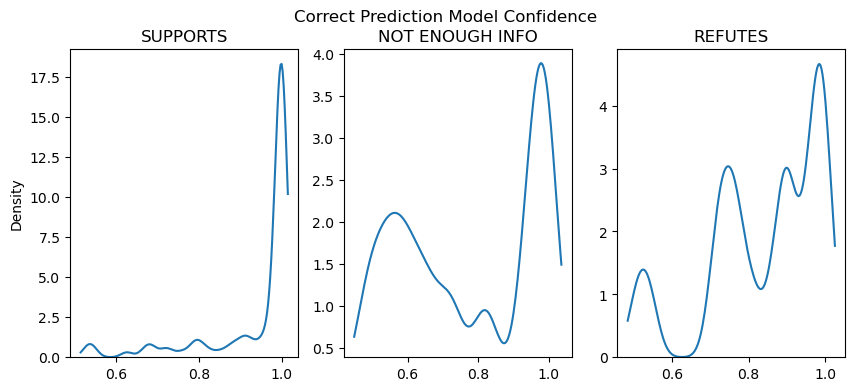

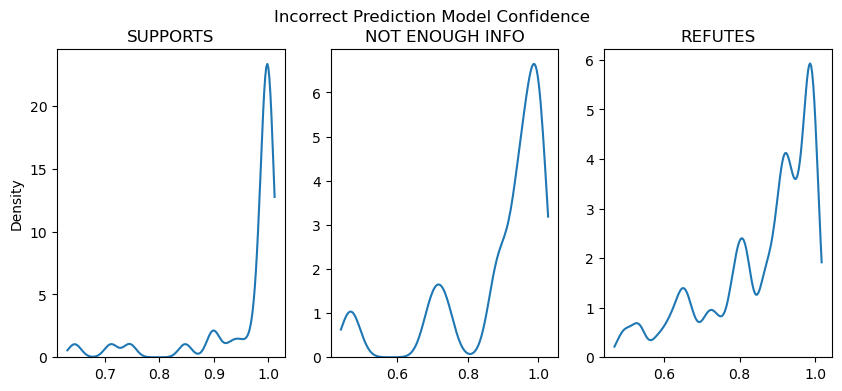

In [160]:
cfever_p5s5_zeroshot_labels = read_data(cfever_zeroshot_p / "p5s5_dev" / "predstage" / "labels.climatefever_dev.jsonl")
_, _ = chart.plot_model_confidence(cf_dev, cfever_p5s5_zeroshot_labels)

In [148]:
for i in keep_rte_eval:
    if list(i.keys())[0] == "p5s4":
        best_keep = i["p5s4"]
        break
print(best_keep["dev"].classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.38      0.71      0.50        95
        REFUTES       0.40      0.04      0.07        51
       SUPPORTS       0.65      0.48      0.56       132

       accuracy                           0.48       278
      macro avg       0.48      0.41      0.37       278
   weighted avg       0.51      0.48      0.45       278



In [149]:
best_keep["dev"].rte_metrics

{'fever_score': 0.4784172661870504,
 'accuracy': 0.4784172661870504,
 'micro_precision': 0.4784172661870504,
 'micro_recall': 0.4784172661870504,
 'micro_f1': 0.4784172661870504,
 'macro_precision': 0.4786394557823129,
 'macro_recall': 0.4097757763392438,
 'macro_f1': 0.3747488689517675}

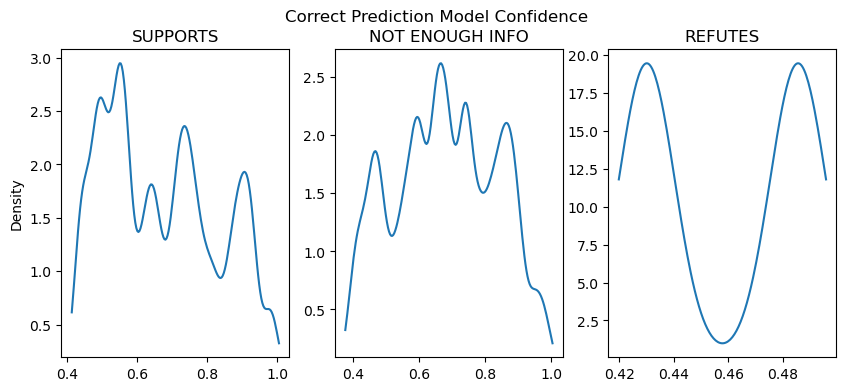

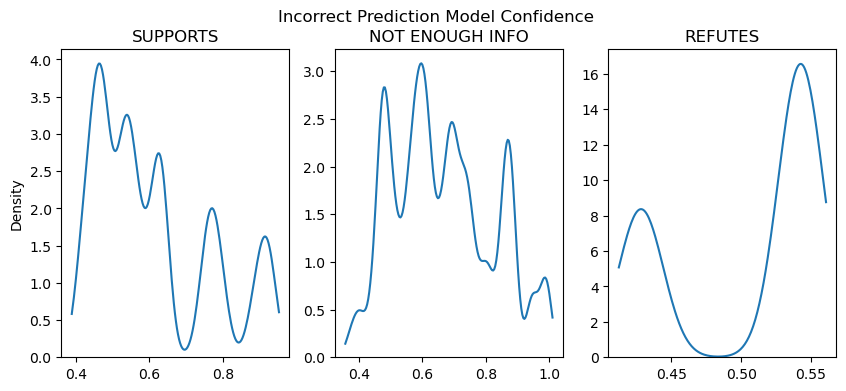

In [165]:
keep_p5s4_labels = read_data(pipeline_keep / "p5s4" / "labels.dev.jsonl")
_, _ = chart.plot_model_confidence(cf_dev, keep_p5s4_labels)

In [150]:
for i in extend_rte_eval:
    if list(i.keys())[0] == "p9s8":
        best_extend = i["p9s8"]
        break
print(best_extend["dev"].classification_report)

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.42      0.57      0.48        95
        REFUTES       0.44      0.16      0.23        51
       SUPPORTS       0.61      0.61      0.61       132

       accuracy                           0.51       278
      macro avg       0.49      0.44      0.44       278
   weighted avg       0.51      0.51      0.50       278



In [151]:
best_extend["dev"].rte_metrics

{'fever_score': 0.5107913669064749,
 'accuracy': 0.5107913669064749,
 'micro_precision': 0.5107913669064749,
 'micro_recall': 0.5107913669064749,
 'micro_f1': 0.5107913669064749,
 'macro_precision': 0.49124537283599956,
 'macro_recall': 0.4437814679300747,
 'macro_f1': 0.44079731137509287}

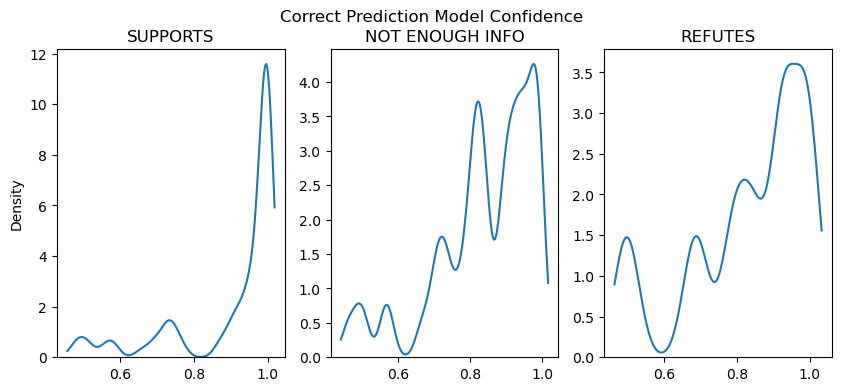

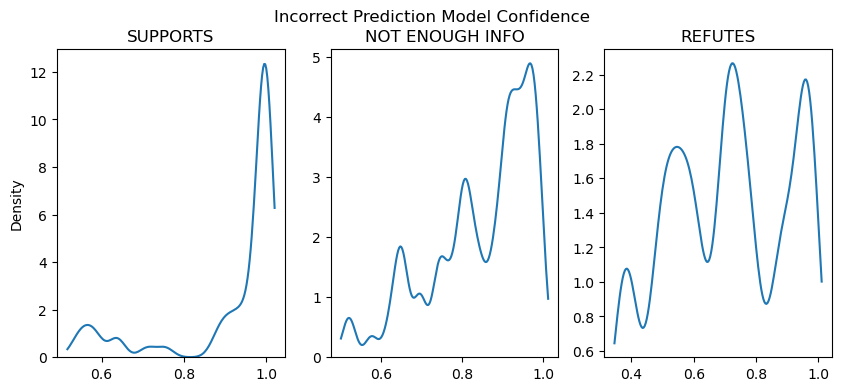

In [166]:
extend_p9s8_labels = read_data(pipeline_extend / "p9s8" / "labels.dev.jsonl")
_, _ = chart.plot_model_confidence(cf_dev, extend_p9s8_labels)

##### TEST Pipeline

In [152]:
cfever_p5s5_test = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/cfever_zeroshot/p5s5_test/pred.climatefever_test.jsonl"))
print(classification_report(y_true=[doc["label"] for doc in cf_test], y_pred=[pred["predicted_label"] for pred in cfever_p5s5_test]))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.44      0.15      0.22        47
        REFUTES       0.24      0.36      0.29        25
       SUPPORTS       0.55      0.71      0.62        65

       accuracy                           0.45       137
      macro avg       0.41      0.41      0.38       137
   weighted avg       0.45      0.45      0.42       137



In [153]:
cfever_keep_p5s4_test = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/best_pipeline/02_keep-vocab_model-15epoch_p5s4/pred.climatefever_test.jsonl"))
print(classification_report(y_true=[doc["label"] for doc in cf_test], y_pred=[pred["predicted_label"] for pred in cfever_keep_p5s4_test]))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.37      0.74      0.50        47
        REFUTES       0.00      0.00      0.00        25
       SUPPORTS       0.61      0.38      0.47        65

       accuracy                           0.44       137
      macro avg       0.33      0.38      0.32       137
   weighted avg       0.42      0.44      0.39       137



In [155]:
cfever_extend_p9s5_test = read_data(Path("/users/k21190024/study/fact-checking-repos/fever/baseline/thesis/zeroshot/finetune/baseline/best_pipeline/01_extend-vocab_model-9epoch_p9s8/pred.climatefever_test.jsonl"))
print(classification_report(y_true=[doc["label"] for doc in cf_test], y_pred=[pred["predicted_label"] for pred in cfever_extend_p9s5_test]))

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.30      0.40      0.35        47
        REFUTES       0.33      0.12      0.18        25
       SUPPORTS       0.51      0.51      0.51        65

       accuracy                           0.40       137
      macro avg       0.38      0.34      0.34       137
   weighted avg       0.41      0.40      0.39       137



/scratch/users/k21190024/envs/conda/p-dis-torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/users/k21190024/envs/conda/p-dis-torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/users/k21190024/envs/conda/p-dis-torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf